# Arthritis Case Study
## Upstream Regulator Analysis Package


----------------------

Author: Mikayla Webster (13webstermj@ucsd.edu)

Date: 9th February, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Load Networks](#load)
4. [Localization](#local)
6. [TF Enrichment and State Prediction](#pz)
8. [Display Our results](#display)

## Background
<a id='background'></a>

The inspiration for these modules comes from Ingenuity System's [Ingenuity Upstream Regulator Analysis in IPA®](http://pages.ingenuity.com/rs/ingenuity/images/0812%20upstream_regulator_analysis_whitepaper.pdf).

This notebook demonstrates how to use our ura package. This notebook creates an instance of class Upstream, and uses this instance to call all of our module's functions. This requires less module imports and simplifies work flow. This notebook emphasizes the flow of function calls, namely what order you should call functions in order for the workflow to process correctly. If you need further help on how to use a function or what that function's purpose is, see the comments associated with that function in the source code (Upstream.py, create_graph.py, or stat_analysis.py).

## Import packages
<a id='import'></a>

In [1]:
# import upstream regulator module
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)
import Upstream
reload(Upstream)

<module 'Upstream' from '../../network_bio_toolkit\Upstream.pyc'>

In [2]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

ura = Upstream.Upstream(gene_type = symbol, species = human)

## Load Networks
<a id='load'></a>

1. List of all **Transcription Factors** (TF's) or regulators of interest to us
    <br>
    - Our sources are [slowkow](https://github.com/slowkow/tftargets) and [jaspar](http://jaspar.genereg.net/) TF databases
    <br><br>
2. **Background Network**: [STRING human protein interactions network](https://string-db.org/cgi/download.pl?UserId=9BGA8WkVMRl6&sessionId=HWUK6Dum9xC6&species_text=Homo+sapiens)  
    - Filter our background network down to just the sub network of TF's and their targets
    <br><br>
3. User-supplied list of **Differentially Expressed Genes** (DEG's)

In [3]:
# transcription factors
ura.easy_load_TF_list('../../TF_databases/TF_database_URA.csv')
TF_list = ura.get('TF_list')
print "Number of TF's: " + str(len(TF_list))

Number of TF's: 3983


../../network_bio_toolkit\create_graph.py:46: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df2 = pd.DataFrame.from_csv(csv_filename)


In [4]:
# background network
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
ura.load_STRING_to_digraph(filename, confidence_filter)
DG_TF = ura.get('DG_TF')

print "\nNumber of interactions: " + str(len(list(DG_TF.edges())))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
34 input query terms found dup hits:
	[(u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000313571', 2), (u'ENSP00000368927', 2),
314 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 28909


In [5]:
# differentially expressed genes
DEG_filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
ura.create_DEG_list(DEG_filename, p_value_filter = 0.05, fold_change_filter = 1, sep = '\t')

DEG_list = ura.get('DEG_list')
print "Number of DEG's: " + str(len(DEG_list))

../../network_bio_toolkit\create_graph.py:366: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df = pd.DataFrame.from_csv(filename, sep = sep)


Number of DEG's: 1456


## Localization 
<a id='local'></a>

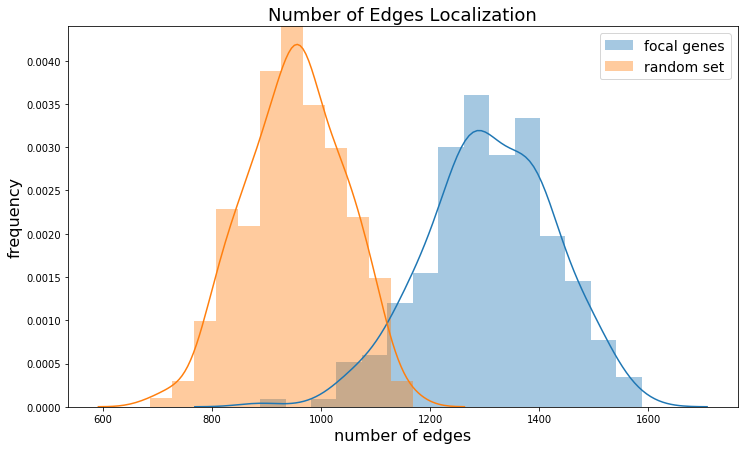

In [6]:
numedges_list, numedges_rand, LCC_list, LCC_rand = ura.localization(num_reps = 250, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'numedges', 
                                                                     plot = True)

1.6764367671839864e-13


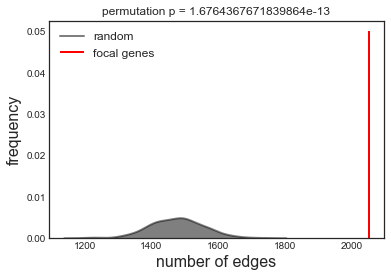

In [7]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = ura.localization_full(num_reps = 200, 
                                                                          method = 'numedges', 
                                                                          label = 'focal genes',
                                                                          line_height = 0.05,
                                                                          legend_loc = 'upper left')

## TF Enrichment and TF Activation State Prediction
<a id='pz'></a>

1. **Enrichment**: How relevant is a TF to its DEG targets? Are they connected by chance, or is their connection statistically significant?
    <br>
    1. -log(p-value) for each TF using [scipy.stats.hypergeom.logsf](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.hypergeom.html).
        1. high value = significant connection between this TF and its DEG targets
        2. low value = TF is randomly associated with its DEG targets
        3. zero = None of this TF's targets were DEG's
        4. inf = original p-value was so small that its log is inf. Very high significance.
        <br><br>
2. **Activation State Prediction**: Activating or inhibiting?

    - activation states: interaction type/regulation direction = predicted state
        - activating/up  = activating
        - activating/down = inhibiting
        - inhibiting/up = inhibiting
        - inhibiting/down = activating
        <br><br>
    - unbiased vs biased calculations:
        - **unbiased calculation**: Assume a normal distribution of activating and inhibiting states 
        - **biased calculation**: For the case when you cannot assume a 50-50 split between up/down-regulated targets and activating/inhbiting interactions. Modify our formula to approximate a normal distribution.

In [8]:
# Enrichment of every TF with respect to its targets
ura.tf_target_enrichment_calc()

# Enrichment of TF's themselves
ura.tf_enrichment_calc()   
ura.get('tf_enrichment')

TF_ENRICHMENT    4.114487e-12
dtype: float64

In [9]:
ura.tf_zscore(bias_filter = 0.25)

## Display Our Results
<a id='display'></a>
- Display TF's with top z-scores
- Display a histogram to see where specific genes rank among others according to z-score
- Display subnetwork of a particular TF and its targets

In [10]:
top_values = ura.top_values(act = True, abs_value = True, top = 5)
display(top_values)

,z-score,(adj) p-value,(log) fold change
STAT1,2.840188,0.826469,0.063822
AHCTF1,2.672612,0.043979,-0.401034
FOXO3,-2.710687,0.000292,-1.125810
GLI2,-2.828427,0.172742,-0.554695
RBL2,-3.162278,0.129498,-0.830733


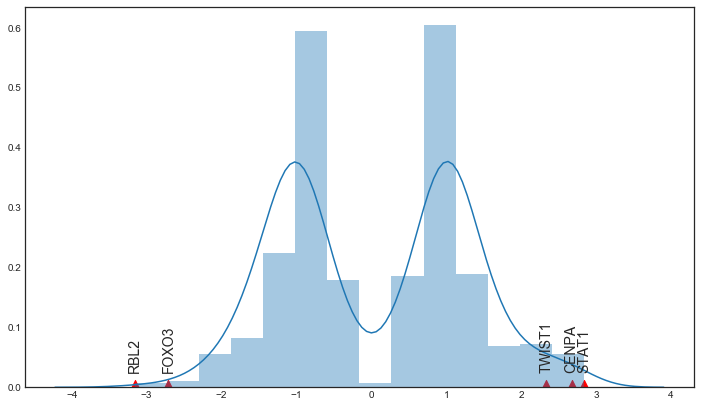

In [11]:
genes_to_rank = ['STAT1', 'CENPA', 'FOXO3', 'TWIST1', 'RBL2']
ura.compare_genes(genes_to_rank, font_size = 14)

In [12]:
ura.vis_tf_network('STAT1',
              directed_edges = True,
              color_non_DEGs = False,
              node_spacing = 3000,
              graph_id = 2,
              tf_size_amplifier = 0)

In [13]:
# display subnetworks using visJS2jupyter
ura.vis_tf_network('RBL2',
              color_non_DEGs = True,
              directed_edges = False,
              node_spacing = 2000,
              graph_id = 1,
              tf_size_amplifier = 0) 

In [14]:
# to write data to a csv file
#csv_filename = 'analysis_arthritis.txt'
#ura.to_csv(csv_filename)